In [887]:
import numpy as np
import pandas as pd

import pymysql
import dotenv
import os
import pickle
import seaborn as sns
import matplotlib

from datetime import timedelta

import matplotlib.pyplot as plt

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# sns.set() 설정값을 리셋해주는 함수
def pltconfig_default() :
  sns.reset_defaults()
  %matplotlib inline

pltconfig_default()

matplotlib.rcParams

matplotlib.rcParams['font.family']

current_font_list = matplotlib.rcParams['font.family']

font_path = 'C:\\Windows\\Fonts\\batang.ttc'

kfont = matplotlib.font_manager.FontProperties(fname=font_path).get_name()

matplotlib.rcParams['font.family'] = [kfont] + current_font_list

In [888]:
dotenv_file = dotenv.find_dotenv()
dotenv.load_dotenv(dotenv_file)

# print(os.environ["db_name"])

# conn = pymysql.connect(
#   host = os.environ['db_host'],
#   port = int(os.environ['db_port']),
#   user = os.environ['db_user'],
#   password = os.environ['db_password'],
#   db = os.environ['db_name']
#   # charset= os.environ['db_charset']
# )

True

In [889]:
# curs = conn.cursor()

# sql = "SELECT cpg, DATE_FORMAT(save_time_id, '%Y-%m-%d'), HOUR(save_time) FROM gsmon_solar_data WHERE rtu_id='24' AND lerr != '57'"
# curs.execute(sql)

# result = curs.fetchall()

# print(result)

In [890]:
# with open('plant_data', 'wb') as file :
#   pickle.dump(result, file)

In [891]:
# with open( "plant_data", "rb" ) as file:
#     data = pickle.load(file)

In [892]:
plant_data = pd.read_pickle('plant_data')

data = pd.DataFrame(plant_data, columns=['누적발전량', '날짜', '시간'])

data.tail()

,누적발전량,날짜,시간
920524,238822000,2023-06-28,19
920525,238822000,2023-06-28,19
920526,238822000,2023-06-28,19
920527,238822000,2023-06-28,19
920528,238822000,2023-06-28,19


In [893]:
# 날짜 분리하기
data['날짜'] = pd.to_datetime(data['날짜'])

data['년'] = data['날짜'].dt.year
data['월'] = data['날짜'].dt.month
data['일'] = data['날짜'].dt.day

data = data[['날짜', '년','월','일','시간','누적발전량']]

year = [2020, 2023]

filter_y = data['년'].isin(year)
pg_data = data.drop(index=data[filter_y].index, axis=0)

pg_data.tail()

,날짜,년,월,일,시간,누적발전량
796473,2022-12-31,2022,12,31,17,204302000
796474,2022-12-31,2022,12,31,17,204302000
796475,2022-12-31,2022,12,31,17,204302000
796476,2022-12-31,2022,12,31,17,204302000
796477,2022-12-31,2022,12,31,17,204302000


In [894]:
# 2021년 1월 1일의 전일 데이터 처리를 위한 2020년 12월 31일 마지막 row 가져오기

filter_l = data['년']==2020

last_data_2020 = data[filter_l]

last_data = (last_data_2020.iloc[-1, :]).to_frame()

last_data= last_data.transpose()

print(last_data.shape)
print(pg_data.shape)

pg_data = pd.concat([last_data, pg_data], axis=0)

pg_data.head()

(1, 6)
(532266, 6)


,날짜,년,월,일,시간,누적발전량
264211,2020-12-31,2020,12,31,17,72059000
264212,2021-01-01,2021,1,1,7,72059000
264213,2021-01-01,2021,1,1,7,72059000
264214,2021-01-01,2021,1,1,7,72059000
264215,2021-01-01,2021,1,1,7,72059000


In [895]:
# 전일 최대 누적 발전량 column 추가

# pg_data = pg_data.reset_index(drop=True)

# for i in range(1, len(pg_data)) :
#   yesterday_date = pg_data.iloc[i]['날짜']-timedelta(days=1)
#   # print(yesterday_date)
#   filter_d = pg_data['날짜'] == yesterday_date.strftime('%Y-%m-%d')
#   pg_data.loc[i, '전일최대누적발전량'] = max(pg_data[filter_d]['누적발전량'])


# pg_data.loc[0]['누적발전량']

# for문 적용 테스트
# yesterday_date = pg_data.iloc[1]['날짜']-timedelta(days=1)
# filter_d = pg_data['날짜'] == yesterday_date.strftime('%Y-%m-%d')
# pg_data.loc[2, '전일최대누적발전량'] = max(pg_data[filter_d]['누적발전량'])
# print(pg_data)
# print(yesterday_date.strftime('%Y-%m-%d'))

In [896]:
# pg_data = pg_data.iloc[1:, :]
# print(pg_data.tail())

# with open('plant_data_addy', 'wb') as file :
#   pickle.dump(pg_data, file)

In [897]:
with open('plant_data_addy', 'rb') as file :
  data = pickle.load(file)
  
# print(data)


# 금일 누적 발전량

# 오류치 조정

# 5월 29일 노이즈 값 조정
data.loc[374498, '누적발전량'] = 165871000
# 5월 30일 전일데이터 조정
filter_err = (data['년']==2022) & (data['월']==5) & (data['일']==30)
data['전일최대누적발전량'][filter_err] = 166157000
# 6월 4일 전일데이터 조정
filter_err2 = (data['년']==2022) & (data['월']==6) & (data['일']==4)
data['전일최대누적발전량'][filter_err2] = 167478000

# 6월 3일 노이즈 값 조정
data.loc[379551, '누적발전량'] = 167476000

print(data[filter_err]['누적발전량'])

data['금일누적발전량'] = data['누적발전량'] - data['전일최대누적발전량']


# data.to_csv('test_1.csv', encoding='cp949')  
# print(data.tail())
# 샘플 데이터 (금일 누적 데이터 확인)
# filter_test = data['날짜'] == '2022-5-29'
# fig, axe = plt.subplots(figsize=(12, 8), layout='constrained')
# axe.bar(data[filter_test]['시간'], data[filter_test]['금일누적발전량'], color='g', label='금일누적발전량')

375325    166157000
375326    166157000
375327    166157000
375328    166157000
375329    166157000
            ...    
376174    166389000
376175    166389000
376176    166389000
376177    166389000
376178    166389000
Name: 누적발전량, Length: 854, dtype: object


In [898]:
# 시간대별 발전량 산출

dg = data.groupby(["년","월","일","시간"])['금일누적발전량'].max()

dg = dg.reset_index()

for i in range(1, len(dg)) :
  if dg.loc[i, '금일누적발전량'] - dg.loc[i-1, '금일누적발전량'] < 0 :
    dg.loc[i, '금일발전량'] = 0
  else :
    dg.loc[i, '금일발전량'] = dg.loc[i, '금일누적발전량'] - dg.loc[i-1, '금일누적발전량']

data = dg.fillna(0.0)
  
# data.to_csv('test_2.csv', encoding='cp949')  
# print(data)

# 샘플 데이터 (금일 누적 데이터 확인)
# filter_test = (data['년'] == 2022) & (data['월'] == 12) & (data['일'] == 29)

# print(data[filter_test])

# fig, axe = plt.subplots(figsize=(12, 8), layout='constrained')
# axe.bar(data[filter_test]['시간'], data[filter_test]['금일발전량'], color='g', label='금일발전량')

# print(data[filter_test]['금일발전량'].sum())  # 실데이터 비교 결과 일치


pg_data = data[['년', '월', '일', '시간', '금일발전량']]

print(pg_data.tail())

         년   월   일  시간    금일발전량
9667  2022  12  31  13  34000.0
9668  2022  12  31  14  28000.0
9669  2022  12  31  15  17000.0
9670  2022  12  31  16   5000.0
9671  2022  12  31  17   1000.0


In [899]:
# 밀양시 기상 데이터 추출
for year in range(2021, 2023) :
  globals()['weather_'+str(year)] = f'OBS_ASOS_TIM_{year}.csv'
  globals()['w_data_'+str(year)] = pd.read_csv(globals()['weather_'+str(year)], encoding='cp949')
  
w_data = pd.concat((w_data_2021, w_data_2022), axis=0)

w_data = w_data.fillna(0.0)

w_data['일시'] = pd.to_datetime(w_data['일시'], format='%Y-%m-%d %H:%M', errors='raise')
w_data['년'] = w_data['일시'].dt.year
w_data['월'] = w_data['일시'].dt.month
w_data['일'] = w_data['일시'].dt.day
w_data['시간'] = w_data['일시'].dt.hour


w_data.columns = ['지점', '지역', '일시', '기온', '강수량', '풍속', '풍향', '습도', '일조시간', '일사량', '적설량', 
                  '전운량', '시정', '지면온도', '년', '월', '일', '시간']
w_data = w_data[['년', '월', '일', '시간', '강수량', '풍속', '풍향', '습도', '일조시간', '일사량', '적설량', '전운량', '시정', '지면온도']]

w_data.tail()

,년,월,일,시간,강수량,풍속,풍향,습도,일조시간,일사량,적설량,전운량,시정,지면온도
8754,2022,12,31,19,0.0,0.8,360.0,47.0,0.0,0.0,0.0,0.0,2879.0,-1.1
8755,2022,12,31,20,0.0,0.1,0.0,53.0,0.0,0.0,0.0,0.0,2823.0,-1.6
8756,2022,12,31,21,0.0,0.0,0.0,62.0,0.0,0.0,0.0,0.0,2567.0,-2.3
8757,2022,12,31,22,0.0,0.6,320.0,70.0,0.0,0.0,0.0,0.0,2047.0,-2.8
8758,2022,12,31,23,0.0,0.1,0.0,75.0,0.0,0.0,0.0,0.0,1592.0,-3.3


In [900]:
pg_df = pg_data.set_index(['년','월','일','시간'])
w_df = w_data.set_index(['년','월','일','시간'])

df = w_df.join(pg_df)

df.reset_index(inplace=True)
df = df.fillna(0.0)

# 일조시간은 해당 시간대에 이전의 1시간 일조시간을 나타내므로 시프트 필요
df['일조시간'] = df['일조시간'].shift(-1)

df.tail()

,년,월,일,시간,강수량,풍속,풍향,습도,일조시간,일사량,적설량,전운량,시정,지면온도,금일발전량
17513,2022,12,31,19,0.0,0.8,360.0,47.0,0.0,0.0,0.0,0.0,2879.0,-1.1,0.0
17514,2022,12,31,20,0.0,0.1,0.0,53.0,0.0,0.0,0.0,0.0,2823.0,-1.6,0.0
17515,2022,12,31,21,0.0,0.0,0.0,62.0,0.0,0.0,0.0,0.0,2567.0,-2.3,0.0
17516,2022,12,31,22,0.0,0.6,320.0,70.0,0.0,0.0,0.0,0.0,2047.0,-2.8,0.0
17517,2022,12,31,23,0.0,0.1,0.0,75.0,NaN,0.0,0.0,0.0,1592.0,-3.3,0.0


In [901]:
# with open('final_data', 'wb') as file :
#   pickle.dump(df, file)

In [902]:
with open('final_data', 'rb') as file :
  data = pickle.load(file)
    
# filter_test = (data['년'] == 2022) & (data['월'] == 5) & (data['일'] == 3)
# data[filter_test]['금일발전량']

data.iloc[:, 4:].describe()

,강수량,풍속,풍향,습도,일조시간,일사량,적설량,전운량,시정,지면온도,금일발전량
count,17518.000000,17518.000000,17518.000000,17518.000000,17517.000000,17518.0,17518.000000,17518.000000,17518.000000,17518.000000,17518.000000
mean,0.116777,1.089828,140.401302,61.817274,0.274139,0.0,0.000086,4.928645,2336.877269,16.408785,7522.534993
std,1.031508,0.964430,132.421098,22.557304,0.411500,0.0,0.005500,3.991391,1530.613062,13.342216,11300.716530
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-11.500000,0.000000
25%,0.000000,0.400000,0.000000,45.000000,0.000000,0.0,0.000000,0.000000,1300.000000,5.725000,0.000000
50%,0.000000,0.800000,140.000000,65.000000,0.000000,0.0,0.000000,6.000000,2000.000000,17.000000,0.000000
75%,0.000000,1.600000,270.000000,82.000000,0.600000,0.0,0.000000,9.000000,3399.000000,25.500000,13000.000000
max,37.900000,7.600000,360.000000,99.000000,1.000000,0.0,0.400000,10.000000,44350.000000,58.900000,178000.000000


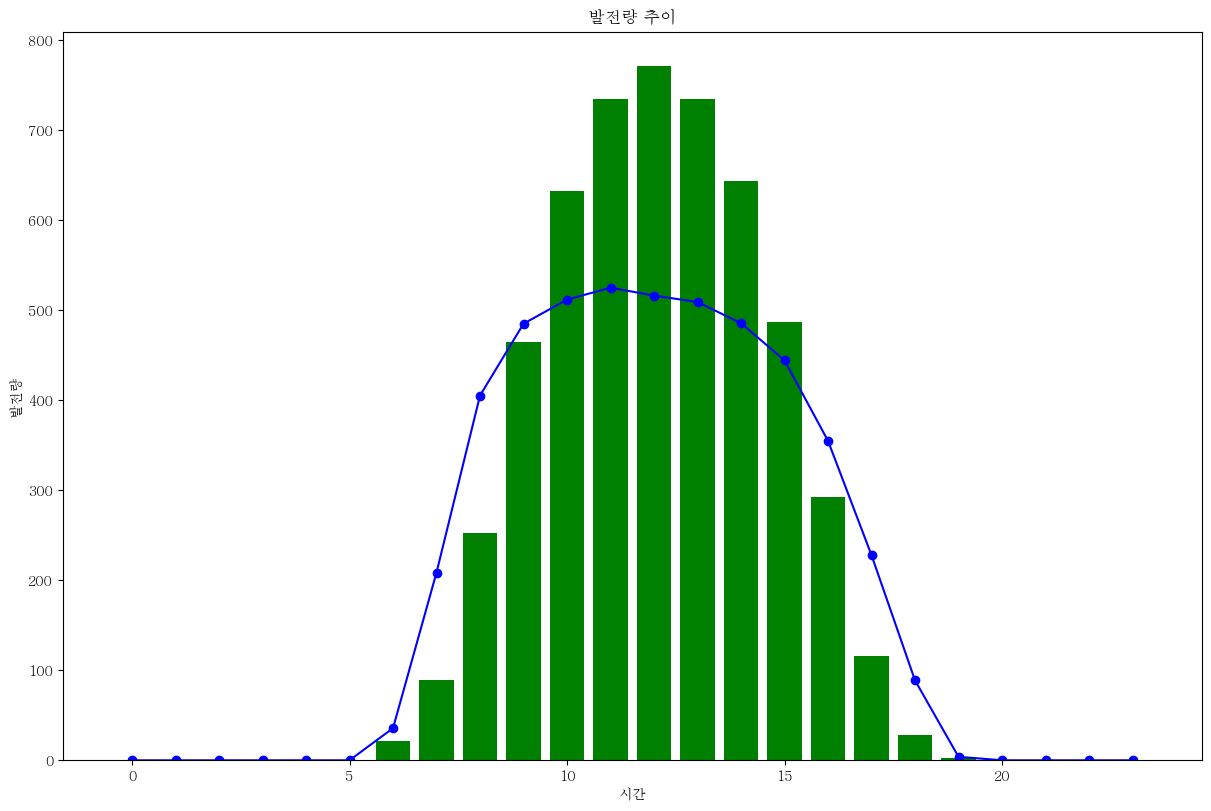

In [903]:
# 데이터 확인

g1 = data.groupby('시간')
gr1 = g1.sum()

# 일조시간은 해당 시간대에 이전의 1시간 일조시간을 나타내므로 시프트 필요
# gr1['일조시간'] = gr1['일조시간'].shift(-1)
# gr1['일조시간'].fillna(0.0)


# 오류치 확인 (2022년 5월 29일,30일, 6월 3일,4일 일부 노이즈 값(누적발전량값 오류, 전일데이터 미반영) 조정)
# filter_t = data['시간'] == 5
# max(data[filter_t]['금일발전량'])
# filter_d = (data['년'] == 2022) & (data['월'] == 5) & (data['일'] == 30)
# data[filter_d]['금일발전량']


fig, axe = plt.subplots(figsize=(12, 8), layout='constrained')

axe.set_title('발전량 추이')
axe.set_xlabel("시간")
axe.set_ylabel("발전량")



# axe.bar(gr1.index, gr1['금일발전량']/10000000, color='g', label='금일발전량(/10)')
axe.bar(gr1.index, gr1['금일발전량']/25000, color='g', label='금일발전량(kWh/25)')
# axe.plot(gr1.index, gr1['일사량'], color='r', marker='x', label='일사량')
axe.plot(gr1.index, gr1['일조시간'], color='b', marker='o', label='일조시간')